# Data Preprocessing

**Prerequisite : EDA.ipynb**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# Algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
df = pd.read_excel("../artifacts/raw/E Commerce Dataset.xlsx", sheet_name="E Comm", index_col=0)

### Drop Cashback Amount

After the first iteration of training, we realized the dropped null values model performed better even on imputed datasets, this could be due to imputation inaccuracy on the Cashback Amount column which has too many null values (>2000).

In [6]:
df.drop(columns=["CashbackAmount"], inplace=True)

### One Hot Encoding

In [7]:
# One hot encoding to prepare for iterative imputation
categorical_columns = ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus"] # for one hot encoding, exclude columns that are already binary
numerical_columns = [col for col in df.columns if col not in categorical_columns] # Churnhas been dropped above
df_one_hot = pd.get_dummies(df, columns=categorical_columns, dtype=int)

df_one_hot.head()

,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
CustomerID,,,,,,,,,,,,,,,,,,,,,
50001,1,4.0,6.0,3.0,3,2,9,1,11.0,1.0,...,0,0,0,1,0,0,0,0,0,1
50002,1,NaN,8.0,3.0,4,3,7,1,15.0,0.0,...,1,0,0,0,1,0,0,0,0,1
50003,1,NaN,30.0,2.0,4,3,6,1,14.0,0.0,...,1,0,0,0,1,0,0,0,0,1
50004,1,0.0,15.0,2.0,4,5,8,0,23.0,0.0,...,1,0,0,1,0,0,0,0,0,1
50005,1,0.0,12.0,NaN,3,5,3,0,11.0,1.0,...,1,0,0,0,1,0,0,0,0,1


### Handle Null values

In [8]:
# Copy of dataset with dropped null values
df_dropped = df_one_hot.dropna()

print("Before: ", df_one_hot.shape)
print("After: ", df_dropped.shape)
print("Dropped: ", df_one_hot.shape[0] - df_dropped.shape[0])

Before:  (5630, 36)
After:  (3774, 36)
Dropped:  1856


In [9]:
# Imputing with Iterative Imputer
imputer = IterativeImputer(random_state=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df_one_hot), columns=df_one_hot.columns)

df_imputed.head()

,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1.0,4.000000,6.0,3.000000,3.0,2.0,9.0,1.0,11.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,2.549240,8.0,3.000000,4.0,3.0,7.0,1.0,15.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,3.672123,30.0,2.000000,4.0,3.0,6.0,1.0,14.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.000000,15.0,2.000000,4.0,5.0,8.0,0.0,23.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.000000,12.0,2.237088,3.0,5.0,3.0,0.0,11.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [10]:
print("Before: ", df_one_hot.shape)
print("After: ", df_imputed.shape)
print("Dropped: ", df_one_hot.shape[0] - df_imputed.shape[0])

Before:  (5630, 36)
After:  (5630, 36)
Dropped:  0


In [11]:
# Drop Target variable 
y_dropped = df_dropped["Churn"]
df_dropped = df_dropped.drop(columns=['Churn'],axis=1)
y_imputed = df_imputed["Churn"]
df_imputed = df_imputed.drop(columns=['Churn'],axis=1)
df.drop(columns=['Churn'],axis=1, inplace=True)

categorical_columns = ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus"] # for one hot encoding, exclude columns that are already binary
numerical_columns = [col for col in df.columns if col not in categorical_columns] # Churnhas been dropped above

In [12]:
df_dropped

,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,...,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
CustomerID,,,,,,,,,,,,,,,,,,,,,
50001,4.0,6.0,3.0,3,2,9,1,11.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,1
50004,0.0,15.0,2.0,4,5,8,0,23.0,0.0,1.0,...,1,0,0,1,0,0,0,0,0,1
50006,0.0,22.0,3.0,5,5,2,1,22.0,4.0,6.0,...,0,0,0,0,0,1,0,0,0,1
50012,11.0,6.0,3.0,4,3,10,1,13.0,0.0,1.0,...,1,1,0,0,0,0,0,0,0,1
50013,0.0,11.0,2.0,3,3,2,1,13.0,2.0,2.0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55625,1.0,12.0,2.0,5,3,2,0,19.0,2.0,2.0,...,0,0,0,0,0,1,0,0,0,1
55626,10.0,30.0,3.0,2,1,6,0,18.0,1.0,2.0,...,1,0,0,1,0,0,0,0,1,0
55628,1.0,11.0,3.0,2,4,3,1,21.0,1.0,2.0,...,1,0,0,1,0,0,0,0,1,0


### Handle outliers

In [13]:
def drop_outliers(df_version, columns, threshold=1.5):
    df_no_outliers = df_version.copy()
    for col in columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] > lower_bound) & (df_no_outliers[col] < upper_bound)]
    return df_no_outliers

# droped null values with outliers
df_dropped_with_outliers = df_dropped
# droped null values no outliers
df_dropped_no_outliers = drop_outliers(df_dropped, ['Tenure'])
# imputed null values with outliers
df_imputed_with_outliers = df_imputed
# imputed null values without outliers
df_imputed_no_outliers = drop_outliers(df_imputed, [x for x in numerical_columns if x != "Complain"])

all_df = [df_dropped_with_outliers, df_dropped_no_outliers, df_imputed_with_outliers, df_imputed_no_outliers]
for df in all_df:
    print(df.shape)

(3774, 35)
(3749, 35)
(5630, 35)
(3839, 35)


We cannot remove outliers from numerical variables as they are merely result of insufficient samples. This is because when we remove all outliers from all numerical columns, there will be few rows left. If we remove outliers, the accuracy of our model may be high, but will fail when we are met with outliers during inference, which we will as there are 2000+ rows with outliers in this dataset alone.

In [14]:
# Keep outliers
all_df = [df_dropped_with_outliers, df_imputed_with_outliers]

### Features Selection using Variational Inflation Factor

VIF is used to detect multicollinearity in numerical features. VIF value of more than 5 means high multicollinearity, which means the variables are redundant and can be removed.

In [15]:
def select_features_with_variance_threshold(data, threshold=5.0):

    numerical_data = data[[x for x in numerical_columns if x != "Complain"]]
    categorical_data = data.drop(columns=numerical_columns, errors='ignore')

    selector = VarianceThreshold(threshold)
    selector.fit(numerical_data)
    selected_numerical_features = numerical_data.columns[selector.get_support(indices=True)]

    selected_data = pd.concat([data[selected_numerical_features], categorical_data], axis=1)

    return selected_data

# Calculate VIF and select features < 5.0 VIF
df_feature_selected = []
for df in all_df:
    df_feature_selected.append(select_features_with_variance_threshold(df.drop(columns=["Complain"]))) # Exclude target column

# Print the result
for i in range(len(all_df)):
    excluded_columns = [col for col in all_df[i].columns if col not in df_feature_selected[i].columns]
    print(excluded_columns)

['HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'Complain', 'CouponUsed']
['HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'Complain', 'CouponUsed']


In [16]:
df_feature_selected[0].shape

(3774, 30)

These columns are multicollinear which means they are strongly correlated with each other, it will cause interpretation difficulties, reduce statistical power, and inefficient use of data.

We need to add the "Complain" column back as we dropped it before calculating VIF as it is a categorical variable. We also need to keep one variable from the list of multicollinear variables.

In [17]:
# Add Churn back to our data
for i in range(len(df_feature_selected)):
    df_feature_selected[i]["Complain"] = all_df[i]["Complain"]
    # We will add back satisfaction score as it is highly correlated to Churn
    df_feature_selected[i]['SatisfactionScore']=all_df[i]['SatisfactionScore']

print(df_feature_selected[0].shape)
print(df_feature_selected[1].shape)

(3774, 32)
(5630, 32)


### Standardizing

In [18]:
# Exclude removed features from numerical features
numerical_columns = [x for x in numerical_columns if x not in excluded_columns or x == "Complain"]
numerical_columns

['Tenure',
 'WarehouseToHome',
 'NumberOfAddress',
 'Complain',
 'OrderAmountHikeFromlastYear',
 'OrderCount',
 'DaySinceLastOrder']

In [19]:
# Initialize StandardScaler
scaler = StandardScaler()
numerical_columns_to_scale = [x for x in numerical_columns if x != "Complain"]
# Standardize numerical columns
for df in df_feature_selected:
    df[numerical_columns_to_scale] = scaler.fit_transform(df[numerical_columns_to_scale]) # passed by reference

In [20]:
df_feature_selected[1]

,Tenure,WarehouseToHome,NumberOfAddress,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,CityTier_1,...,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain,SatisfactionScore
0,-0.707510,-1.152597,1.852616,-1.312903,-0.703890,0.100369,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
1,-0.879262,-0.912846,1.078430,-0.198271,-0.703890,-1.282305,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
2,-0.746327,1.724416,0.691336,-0.476929,-0.703890,-0.452700,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
3,-1.181061,-0.073718,1.465523,2.030993,-0.703890,-0.452700,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0
4,-1.181061,-0.433344,-0.469944,-1.312903,-0.703890,-0.452700,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0.002815,1.724416,0.691336,0.637703,-0.365824,-0.176166,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5626,0.357977,-0.313469,0.691336,0.080387,-0.365824,0.084700,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
5627,-1.062673,-0.553220,-0.469944,1.473677,-0.365824,-0.176166,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0
5628,1.541852,-0.792971,-0.082850,-0.198271,-0.365824,1.206508,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0


# Model Training

### Train Test Split

In [21]:
# Train Test Splitting

# Dataset with null values dropped
X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped = train_test_split(df_feature_selected[0], y_dropped, test_size=0.2, random_state=42)
print("Set dropped: ", X_train_dropped.shape, X_test_dropped.shape)

# Dataset with null values imputed
X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = train_test_split(df_feature_selected[1], y_imputed, test_size=0.2, random_state=42)
print("Set Imputed: ", X_train_imputed.shape, X_test_imputed.shape)

Set dropped:  (3019, 32) (755, 32)
Set Imputed:  (4504, 32) (1126, 32)


### Hyperparameter Grid Search

In [36]:
# Define parameters for each algorithm
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
knn_params = {'n_neighbors': [3, 5, 7]}
rf_params = {'n_estimators': [100, 300], 'max_depth': [3, 5]}
xgb_params = {'learning_rate': [0.1, 0.01], 'max_depth': [3, 5]}
catboost_params = {'iterations': [100, 200], 'learning_rate': [0.03, 0.1]}
adaboost_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
logistic_params = {'C': [0.1, 1, 10]}
naive_bayes_params = {}  # No hyperparameters for GaussianNB

# Initialize models
svm = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
catboost = CatBoostClassifier()
adaboost = AdaBoostClassifier()
logistic = LogisticRegression()
naive_bayes = GaussianNB()

# Define the list of classifiers and their corresponding parameter grids
classifiers = [
    (svm, svm_params),
    (knn, knn_params),
    (rf, rf_params),
    (xgb, xgb_params),
    (catboost, catboost_params),
    (adaboost, adaboost_params),
    (logistic, logistic_params),
    (naive_bayes, naive_bayes_params)
]

Training 1: 
- Dataset: Dropped null values
- Metrics: Accuracy

In [37]:
# Save best models
best_models = []

In [38]:
# Fit dataset 1: dropped
# Run GridSearchCV for each classifier
best_classifier_score = 0
for clf, params in classifiers:
    grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train_dropped, y_train_dropped)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_dropped)

    test_score = accuracy_score(y_test_dropped, y_pred)
    if test_score > best_classifier_score:
        best_classifier = grid_search.best_estimator_
        best_classifier_score = test_score
    print(f"Best parameters for {clf.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {clf.__class__.__name__}: {grid_search.best_score_}")
    print(f"Test score for {clf.__class__.__name__}: {test_score}")
    print("----")

best_models.append(best_classifier)

Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Best score for SVC: 0.9314344392826156
Test score for SVC: 0.937748344370861
----
Best parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best score for KNeighborsClassifier: 0.9026204518247614
Test score for KNeighborsClassifier: 0.928476821192053
----
Best parameters for RandomForestClassifier: {'max_depth': 5, 'n_estimators': 300}
Best score for RandomForestClassifier: 0.8685013124224353
Test score for RandomForestClassifier: 0.895364238410596
----
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5}
Best score for XGBClassifier: 0.9350823146958366
Test score for XGBClassifier: 0.9496688741721855
----
0:	learn: 0.6619288	total: 2.44ms	remaining: 241ms
1:	learn: 0.6310939	total: 4.82ms	remaining: 236ms
2:	learn: 0.6042127	total: 7.13ms	remaining: 230ms
3:	learn: 0.5789425	total: 9.46ms	remaining: 227ms
4:	learn: 0.5571568	total: 12ms	remaining: 227ms
5:	learn: 0.5381118	total: 13.5ms	remaining: 212ms
6:	lea

c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best parameters for LogisticRegression: {'C': 1}
Best score for LogisticRegression: 0.8867181751287709
Test score for LogisticRegression: 0.9086092715231788
----
Best parameters for GaussianNB: {}
Best score for GaussianNB: 0.3126926076021658
Test score for GaussianNB: 0.2847682119205298
----


Training 2: 
- Dataset: Dropped null values
- Metrics: F1

In [39]:
# Run GridSearchCV for each classifier
best_classifier_score = 0
for clf, params in classifiers:
    grid_search = GridSearchCV(clf, params, cv=5, scoring='f1')
    grid_search.fit(X_train_dropped, y_train_dropped)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_dropped)
    test_score = f1_score(y_test_dropped, y_pred)
    if test_score > best_classifier_score:
        best_classifier = grid_search.best_estimator_
        best_classifier_score = test_score
    print(f"Best parameters for {clf.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {clf.__class__.__name__}: {grid_search.best_score_}")
    print(f"Test score for {clf.__class__.__name__}: {test_score}")
    print("----")

best_models.append(best_classifier)

Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Best score for SVC: 0.7869601340917286
Test score for SVC: 0.7751196172248803
----
Best parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best score for KNeighborsClassifier: 0.6924102590764825
Test score for KNeighborsClassifier: 0.7428571428571429
----
Best parameters for RandomForestClassifier: {'max_depth': 5, 'n_estimators': 300}
Best score for RandomForestClassifier: 0.41451482956483954
Test score for RandomForestClassifier: 0.4087591240875912
----
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5}
Best score for XGBClassifier: 0.798291952099611
Test score for XGBClassifier: 0.8020833333333333
----
0:	learn: 0.6619288	total: 2.43ms	remaining: 240ms
1:	learn: 0.6310939	total: 4.74ms	remaining: 232ms
2:	learn: 0.6042127	total: 7.07ms	remaining: 229ms
3:	learn: 0.5789425	total: 9.5ms	remaining: 228ms
4:	learn: 0.5571568	total: 11.9ms	remaining: 227ms
5:	learn: 0.5381118	total: 13.5ms	remaining: 211ms
6:

c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best parameters for LogisticRegression: {'C': 10}
Best score for LogisticRegression: 0.6150728145912916
Test score for LogisticRegression: 0.6195652173913043
----
Best parameters for GaussianNB: {}
Best score for GaussianNB: 0.32789287855944416
Test score for GaussianNB: 0.2761394101876676
----


Training 3: 
- Dataset: Imputed null values
- Metrics: Accuracy

In [40]:
# Run GridSearchCV for each classifier
best_classifier_score = 0
for clf, params in classifiers:
    grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train_imputed, y_train_imputed)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_imputed)

    test_score = accuracy_score(y_test_imputed, y_pred)
    if test_score > best_classifier_score:
        best_classifier = grid_search.best_estimator_
        best_classifier_score = test_score
    print(f"Best parameters for {clf.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {clf.__class__.__name__}: {grid_search.best_score_}")
    print(f"Test score for {clf.__class__.__name__}: {test_score}")
    print("----")

best_models.append(best_classifier)

Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Best score for SVC: 0.9398337649525219
Test score for SVC: 0.9547069271758437
----
Best parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best score for KNeighborsClassifier: 0.9265125169564682
Test score for KNeighborsClassifier: 0.9529307282415631
----
Best parameters for RandomForestClassifier: {'max_depth': 5, 'n_estimators': 100}
Best score for RandomForestClassifier: 0.8705615982241953
Test score for RandomForestClassifier: 0.872113676731794
----
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5}
Best score for XGBClassifier: 0.9391698113207546
Test score for XGBClassifier: 0.9458259325044405
----
0:	learn: 0.6630760	total: 2.9ms	remaining: 287ms
1:	learn: 0.6301269	total: 5.9ms	remaining: 289ms
2:	learn: 0.6021782	total: 8.76ms	remaining: 283ms
3:	learn: 0.5753702	total: 11.5ms	remaining: 276ms
4:	learn: 0.5505824	total: 14.3ms	remaining: 272ms
5:	learn: 0.5308178	total: 16.1ms	remaining: 253ms
6:	l

c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best parameters for LogisticRegression: {'C': 10}
Best score for LogisticRegression: 0.8887670489579479
Test score for LogisticRegression: 0.9156305506216696
----
Best parameters for GaussianNB: {}
Best score for GaussianNB: 0.7397898631150573
Test score for GaussianNB: 0.7806394316163411
----


Training 4: 
- Dataset: Imputed null values
- Metrics: F1

In [41]:
# Run GridSearchCV for each classifier
best_classifier_score = 0
for clf, params in classifiers:
    grid_search = GridSearchCV(clf, params, cv=5, scoring='f1')
    grid_search.fit(X_train_imputed, y_train_imputed)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_imputed)

    test_score = f1_score(y_test_imputed, y_pred)
    if test_score > best_classifier_score:
        best_classifier = grid_search.best_estimator_
        best_classifier_score = test_score
    print(f"Best parameters for {clf.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {clf.__class__.__name__}: {grid_search.best_score_}")
    print(f"Test score for {clf.__class__.__name__}: {test_score}")
    print("----")

best_models.append(best_classifier)

Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Best score for SVC: 0.8080360041424509
Test score for SVC: 0.8513119533527698
----
Best parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best score for KNeighborsClassifier: 0.7683485715890135
Test score for KNeighborsClassifier: 0.8531855955678671
----
Best parameters for RandomForestClassifier: {'max_depth': 5, 'n_estimators': 100}
Best score for RandomForestClassifier: 0.3907721130345492
Test score for RandomForestClassifier: 0.5098039215686275
----
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5}
Best score for XGBClassifier: 0.8028617944292751
Test score for XGBClassifier: 0.8200589970501475
----
0:	learn: 0.6630760	total: 3.23ms	remaining: 319ms
1:	learn: 0.6301269	total: 6.13ms	remaining: 300ms
2:	learn: 0.6021782	total: 8.93ms	remaining: 289ms
3:	learn: 0.5753702	total: 11.8ms	remaining: 282ms
4:	learn: 0.5505824	total: 14.5ms	remaining: 276ms
5:	learn: 0.5308178	total: 16.8ms	remaining: 264ms
6

c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TayXueHao\anaconda3\envs\ek\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

### Evaluation

Comparing models trained on different datasets and metrics

In [42]:
best_models

In [60]:
accuracy_imputed = []
f1_score_imputed = []
accuracy_dropped = []
f1_score_dropped = []

for i, model in enumerate(best_models):
    imputed_predictions = model.predict(X_test_imputed)
    dropped_predictions = model.predict(X_test_dropped)
    print(f"Model {i+1}: ")
    print(f"{model.__class__.__name__} on Imputed Dataset Accuracy: {accuracy_score(imputed_predictions, y_test_imputed)}")
    print(f"{model.__class__.__name__} on Imputed Dataset F1 Score: {f1_score(imputed_predictions, y_test_imputed)}")

    print(f"{model.__class__.__name__} on Dropped Dataset Accuracy: {accuracy_score(dropped_predictions, y_test_dropped)}")
    print(f"{model.__class__.__name__} on Dropped Dataset F1 Score: {f1_score(dropped_predictions, y_test_dropped)}")
    accuracy_imputed.append(accuracy_score(imputed_predictions, y_test_imputed))
    f1_score_imputed.append(f1_score(imputed_predictions, y_test_imputed))
    accuracy_dropped.append(accuracy_score(dropped_predictions, y_test_dropped))
    f1_score_dropped.append(f1_score(dropped_predictions, y_test_dropped))

Model 1: 
CatBoostClassifier on Imputed Dataset Accuracy: 0.9626998223801065
CatBoostClassifier on Imputed Dataset F1 Score: 0.877906976744186
CatBoostClassifier on Dropped Dataset Accuracy: 0.9721854304635762
CatBoostClassifier on Dropped Dataset F1 Score: 0.8944723618090453
Model 2: 
CatBoostClassifier on Imputed Dataset Accuracy: 0.9626998223801065
CatBoostClassifier on Imputed Dataset F1 Score: 0.877906976744186
CatBoostClassifier on Dropped Dataset Accuracy: 0.9721854304635762
CatBoostClassifier on Dropped Dataset F1 Score: 0.8944723618090453
Model 3: 
CatBoostClassifier on Imputed Dataset Accuracy: 0.977797513321492
CatBoostClassifier on Imputed Dataset F1 Score: 0.9295774647887325
CatBoostClassifier on Dropped Dataset Accuracy: 0.9774834437086093
CatBoostClassifier on Dropped Dataset F1 Score: 0.9137055837563453
Model 4: 
CatBoostClassifier on Imputed Dataset Accuracy: 0.977797513321492
CatBoostClassifier on Imputed Dataset F1 Score: 0.9295774647887325
CatBoostClassifier on Drop

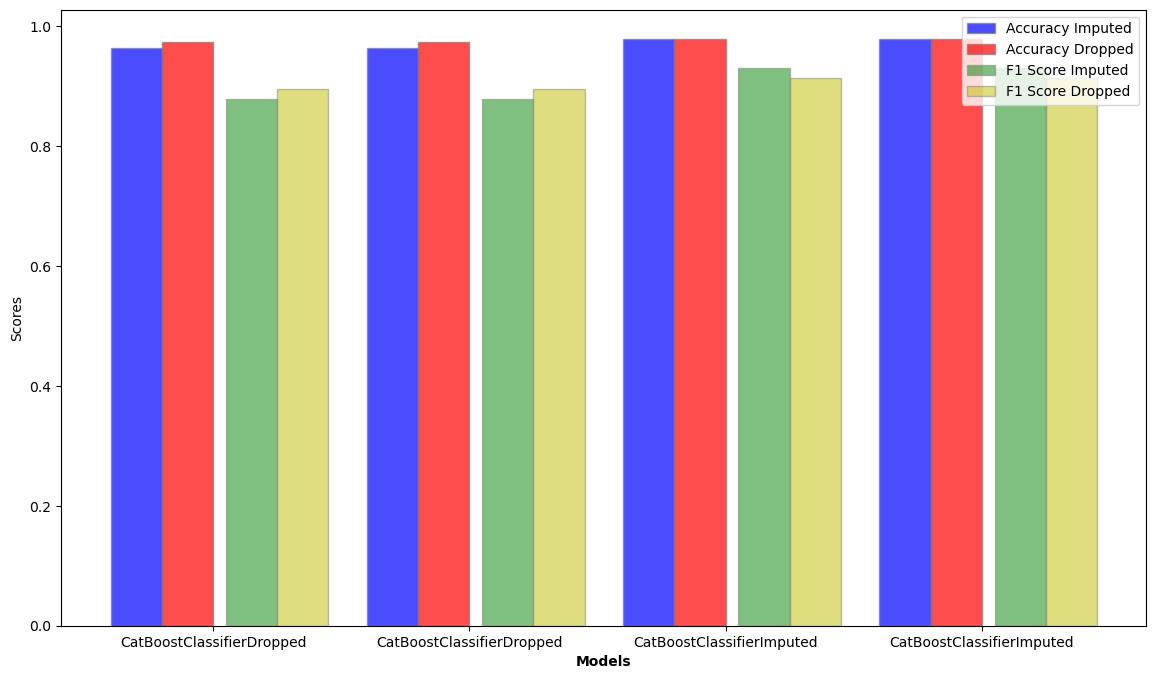

In [68]:
# Assuming you have the accuracy and F1 score values for your models for two datasets
model_names = ["CatBoostClassifierDropped", "CatBoostClassifierDropped", "CatBoostClassifierImputed", "CatBoostClassifierImputed"]

# Set the width of the bars
barWidth = 0.2

# Set position of bars on X axis
r1 = np.arange(len(accuracy_imputed))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth+0.05 for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.figure(figsize=(14, 8))
plt.bar(r1, accuracy_imputed, color='b', width=barWidth, edgecolor='grey', label='Accuracy Imputed', alpha=0.7)
plt.bar(r2, accuracy_dropped, color='r', width=barWidth, edgecolor='grey', label='Accuracy Dropped', alpha=0.7)
plt.bar(r3, f1_score_imputed, color='g', width=barWidth, edgecolor='grey', label='F1 Score Imputed', alpha=0.5)
plt.bar(r4, f1_score_dropped, color='y', width=barWidth, edgecolor='grey', label='F1 Score Dropped', alpha=0.5)

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores')
plt.xticks([r + 1.5 * barWidth for r in range(len(accuracy_imputed))], model_names)

# Create legend & Show graphic
plt.legend()
plt.show()

Conclusion: 
- The Best model trained on the Imputed Dataset outperforms the model trained on Dropped dataset on both dataset versions during testing. 
- The Best model is a CatBoost Classifier Trained on the Imputed Dataset
- Accuracy of best model: 97.77% (On Imputed Dataset)
- F1 score of best model: 92.95% (On Dropped Dataset)
- This implies that we might want to use the IterativeImputation we have trained duirng inference as well.

In [72]:
# Declare best model
best_model = best_models[2] # 3rd and 4th models are the same

Interpreting model using SHAP:
- SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model by quantifying the contribution (aka. weight) of each feature to the prediction.

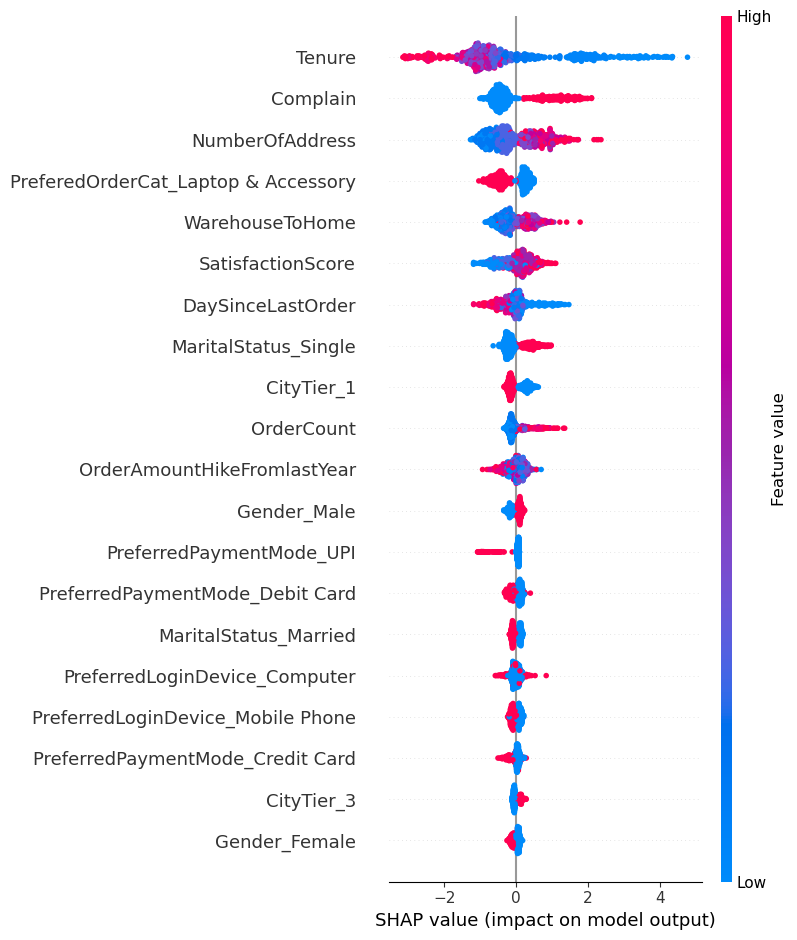

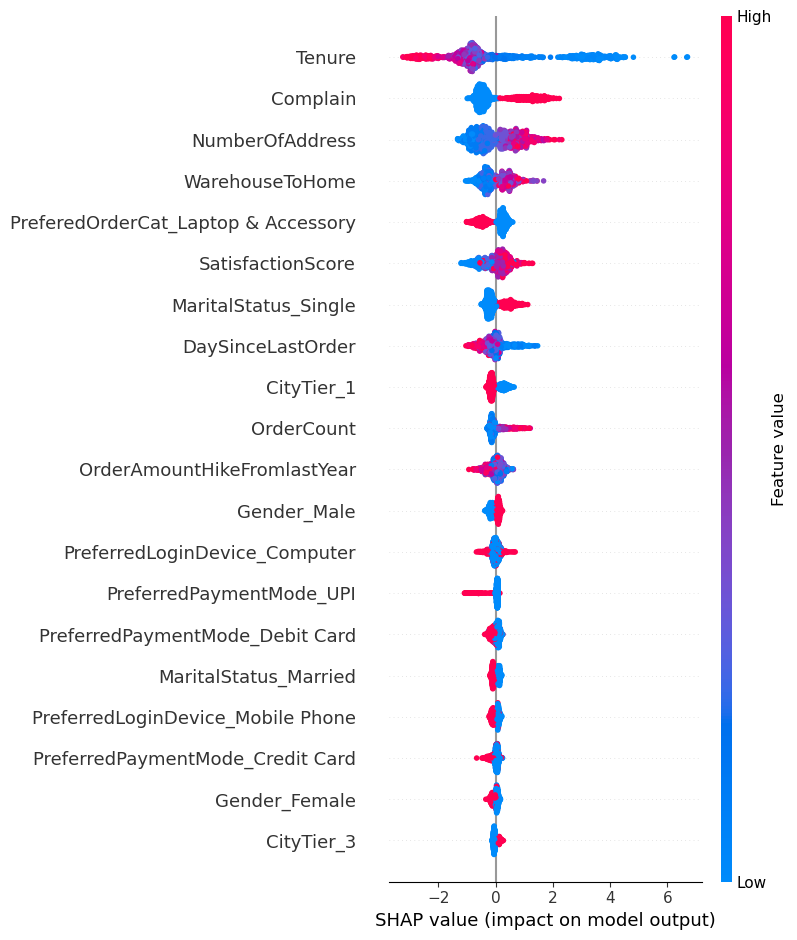

In [102]:
# Explain model predictions using SHAP
explainer1 = shap.TreeExplainer(best_model)
shap_values1 = explainer1.shap_values(X_test_dropped)

explainer2 = shap.TreeExplainer(model)
shap_values2 = explainer2.shap_values(X_test_imputed)

# Create SHAP summary plots
# Dropped
shap.summary_plot(shap_values1, X_test_dropped, plot_type="dot", title="Some")
# Imputed
shap.summary_plot(shap_values2, X_test_imputed, plot_type="dot")

plt.show()

In [86]:
def list_shap_top_10_features(shap_values):
    # Get the absolute mean SHAP values for each feature
    mean_absolute_shap_values1 = np.abs(shap_values).mean(0)

    # Get the indices of the top 10 features
    top10_indices = mean_absolute_shap_values1.argsort()[-10:][::-1]

    # Get the corresponding feature names
    feature_names = list(X_test_dropped.columns)  # Assuming X1_test and X2_test have the same column names

    # Display the top 10 features
    top10_features = [feature_names[i] for i in top10_indices]

    return top10_features

list1 = list_shap_top_10_features(shap_values1) 
list2 = list_shap_top_10_features(shap_values2) 
df_features = pd.DataFrame({'Top 10 Dropped': list1, 'Top 10 Imputed': list2})
df_features

,Top 10 Dropped,Top 10 Imputed
0,Tenure,Tenure
1,Complain,Complain
2,NumberOfAddress,NumberOfAddress
3,PreferedOrderCat_Laptop & Accessory,WarehouseToHome
4,WarehouseToHome,PreferedOrderCat_Laptop & Accessory
5,SatisfactionScore,SatisfactionScore
6,DaySinceLastOrder,MaritalStatus_Single
7,MaritalStatus_Single,DaySinceLastOrder
8,CityTier_1,CityTier_1
9,OrderCount,OrderCount


Insights:
1. Number of address have a positive correlation with churn. Perhaps customers who always move is harder to fulfil.
2. Customers who buy laptop and accesories are less likely to churn.
3. Satisfaction score has a positive correlation with churn which is weird. Need to check back EDA and Data preprocessing.
4. Single customers are more likely to churn.
5. Male are more likely to churn than female.

### 

### Creating pipeline